# MAST30034 Project 1
## Statistical Modelling

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols, glm

In [ ]:
from functools import reduce 
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [ ]:
taxi = spark.read.parquet('../../Project 1/DataFrames/processed')
weather = spark.read.parquet('../../Project 1/DataFrames/weather')
taxi = taxi.withColumn("pickup_date",to_date(col("pickup_time")))
taxi = taxi.drop("pickup_time", "dropoff_time")
sdf = taxi.join(weather,taxi.pickup_date ==  weather.date,"inner")
sdf = sdf.drop('date')



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


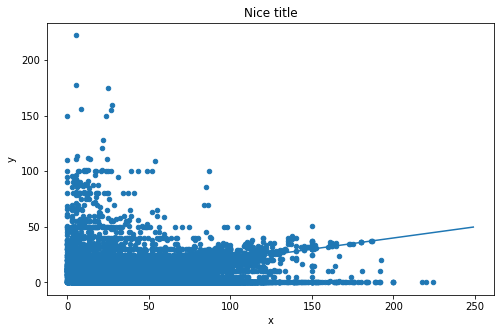

In [36]:
from pyspark.ml.feature import VectorAssembler

features = 'features'
input_cols = ['fare_amount', 'passenger_count', 'pickup_location', 'trip_distance_km', 'temp', 'dew_point', 'pressure', 'wind_speed', 'wind_direction']

assembler = VectorAssembler(
    # which column to combine
    inputCols=['fare_amount', 'passenger_count', 'pickup_location', 'trip_distance_km', 'temp', 'dew_point', 'pressure', 'wind_speed', 'wind_direction'], 
    # How should the combined columns be named
    outputCol= 'features'
)

model_sdf = assembler.transform(sdf.dropna('any'))
# Display the features and targets for our model
# model_sdf.select('features'), model_sdf.select('tip_amount')

In [37]:
from pyspark.ml.regression import LinearRegression

lm = LinearRegression(
    featuresCol='features', 
    labelCol='tip_amount'
).fit(model_sdf)

22/08/10 14:33:10 WARN Instrumentation: [59e39168] regParam is zero, which might cause numerical instability and overfitting.


In [38]:
pd.DataFrame(
    data=[lm.intercept] + list(lm.coefficients),
    index=['intercept'] + input_cols,
    columns=['coefficient']
)

,coefficient
intercept,-1.772666
fare_amount,0.035326
passenger_count,0.033500
pickup_location,0.000060
trip_distance_km,-0.014095
temp,0.001101
dew_point,0.001217
pressure,0.000280
wind_speed,0.001592
wind_direction,0.000033


In [39]:
# example record to predict
sdf.select('tip_amount', *input_cols).limit(1).show(vertical=True)

-RECORD 0-------------------
 tip_amount       | 0.0     
 fare_amount      | 12.0    
 passenger_count  | 1       
 pickup_location  | 77      
 trip_distance_km | 4.699   
 temp             | 100.5   
 dew_point        | 28.3    
 pressure         | 10111.3 
 wind_speed       | 21.3    
 wind_direction   | 320.3   



In [40]:
# preprocess for predictions
predict_test = sdf.select(*input_cols).limit(1)

assembler = VectorAssembler(
    inputCols=input_cols, 
    outputCol=features
)

predict_sdf = assembler.transform(predict_test).select(features)

predict_sdf.show(1, vertical=True)

-RECORD 0------------------------
 features | [12.0,1.0,77.0,4.... 



In [41]:
predictions = lm.transform(predict_sdf)
predictions.show(vertical=True, truncate=False)

-RECORD 0-----------------------------------------------------------------------------------------------------------
 features   | [12.0,1.0,77.0,4.699,100.5,28.299999237060547,10111.2998046875,21.299999237060547,320.29998779296875] 
 prediction | 1.6457478390463585                                                                                    



In [42]:
# r2 example
lm.summary.r2

0.026380803340281256

In [ ]:
fit_weather = ols(
    formula="tip_amount ~ temp + dew_point + pressure + wind_speed + wind_direction",
    data=df
).fit()

fit_taxi = ols(
    formula="tip_amount ~ pickup_location + passenger_count + fare_amount + trip_distance_km",
    data=df
).fit()

fit_all = ols(
    formula="tip_amount ~ temp + dew_point + pressure + wind_speed + wind_direction + pickup_location + passenger_count + fare_amount + trip_distance_km",
    data=df
).fit()


In [ ]:
print(fit_all.summary())